In [81]:
import sys
# caution: path[0] is reserved for script path (or '' in REPL)
sys.path.insert(1, '../utils')

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from dataset import RigNetDataset, collate_fn, FILE_PATHS, POS_ATTN_AVG
from models import JointNet, JointDisplacementModule, VertexAttentionModule, GMEdgeConv, GMEdgeNet
from visualization_utils import visualize_mesh_graph, visualize_attention_heatmap
from training_utils import chamfer_loss

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support, precision_recall_curve

In [41]:
dataset = RigNetDataset(FILE_PATHS['val'], num_samples=4, seed=42)
dl = DataLoader(
    dataset=dataset,
    batch_size=2,
    shuffle=False,
    collate_fn=collate_fn
)

In [48]:
model = JointNet(edge_dropout=0)
device = 'cpu'
model.to(device)

JointNet(
  (feature_extractor): JointFeatureNet(
    (disp_head): JointDisplacementModule(
      (model): GMEdgeNet(
        (conv1): GMEdgeConv(
          (mlp_topo): Sequential(
            (0): Linear(in_features=6, out_features=64, bias=True)
            (1): ReLU()
            (2): Linear(in_features=64, out_features=64, bias=True)
            (3): ReLU()
          )
          (mlp_geo): Sequential(
            (0): Linear(in_features=6, out_features=64, bias=True)
            (1): ReLU()
            (2): Linear(in_features=64, out_features=64, bias=True)
            (3): ReLU()
          )
          (mlp_fuse): Sequential(
            (0): Linear(in_features=128, out_features=64, bias=True)
            (1): ReLU()
          )
        )
        (conv2): GMEdgeConv(
          (mlp_topo): Sequential(
            (0): Linear(in_features=128, out_features=256, bias=True)
            (1): ReLU()
            (2): Linear(in_features=256, out_features=256, bias=True)
            (3): ReL

### Attention Module

In [72]:
attn_module = VertexAttentionModule()

In [94]:
class SimpleAttentionModule(nn.Module):

    def __init__(self):
        super().__init__()
        self.conv = GMEdgeConv(3, 64)
        self.mlp = nn.Sequential(
            nn.Linear(64, 256),
            nn.ReLU(),
            nn.Linear(256, 1)
        )

    def forward(self, vertices, one_ring, geodesic):
        return self.mlp(self.conv(vertices, one_ring, geodesic))

In [95]:
simple_attn_module = SimpleAttentionModule()

In [96]:
POS_ATTN_AVG, (1 - POS_ATTN_AVG) / POS_ATTN_AVG

(0.2964, 2.3738191632928474)

In [ ]:
epochs = 10000
lr = 1e-4
wd = 0
optimizer = torch.optim.AdamW(attn_module.parameters(), lr=lr, weight_decay=wd)
pos_cls_weight = torch.tensor((1 - POS_ATTN_AVG) / POS_ATTN_AVG)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_cls_weight)

In [ ]:
loss_over_epochs = []
for epoch in range(1, epochs+1):
    model.train()
    epoch_loss = 0.0
    total_batches = 0
    for batch in tqdm(dl, desc=f"Epoch {epoch}/{epochs}"):

        batch_size = batch['vertices_per_graph'].size(0)

        logits = attn_module(
            batch['vertices'],
            batch['one_ring'],
            batch['geodesic']
        ).squeeze()
        loss = criterion(logits, batch['attn_mask'])

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        total_batches += 1
    epoch_loss /= total_batches

    loss_over_epochs.append(epoch_loss)
    print(f"[Epoch {epoch}] loss={epoch_loss:.4f}")


plt.figure()
plt.semilogy(loss_over_epochs)
plt.title("Loss over epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

In [ ]:
for batch in dl:
    attn_pred_probs = F.sigmoid(attn_module(
        batch['vertices'],
        batch['one_ring'],
        batch['geodesic']
    ).squeeze())
    attn_preds = (attn_pred_probs >= 0.5).long()

    attn_pred_probs = attn_pred_probs.detach().numpy()

    print("Accuracy:", accuracy_score(batch['attn_mask'], attn_preds))
    print(confusion_matrix(batch['attn_mask'], attn_preds, labels=[0, 1]))

    # We want high recall for the positive class. 
    # High precision as well of course, but we would rather incorrectly predict more masked vertices than not
    print(precision_recall_fscore_support(batch['attn_mask'], attn_preds, labels=[0, 1]))

    precision, recall, thresh = precision_recall_curve(batch['attn_mask'], attn_pred_probs)
    print(precision, recall, thresh)

    # prepare the staggered, concatenated scene
    # Do it in numpy from the get-go
    verts = batch['vertices'].detach().clone()
    edges = batch['one_ring'].T.detach()

    vpg = batch['vertices_per_graph']

    vertex_splits = torch.split(torch.arange(verts.size(0)), vpg.tolist())

    # We also need the joint counts per graph to split all_joints
    all_joints = torch.cat(batch['joints_list']).detach().clone()
    jp_counts = [j.size(0) for j in batch['joints_list']]
    joint_splits = torch.split(torch.arange(all_joints.size(0)), jp_counts)

    delta = 0.7
    for i, (v_idxs, j_idxs) in enumerate(zip(vertex_splits, joint_splits)):
        # add z-offset
        verts[v_idxs, 2] += i * delta
        all_joints[j_idxs, 2] += i * delta

    print("---")

    visualize_attention_heatmap(
        verts=verts.numpy(),
        edges=edges.numpy(),
        attn_pred=attn_pred_probs,
        joints_gt=all_joints,
        color_low=np.array([0.0, 0.0, 1.0]),
        color_high=np.array([0.0, 1.0, 0.0])
    )

Accuracy: 0.7856313257010121
[[3085 1206]
 [  86 1650]]
(array([0.97287922, 0.57773109]), array([0.71894663, 0.95046083]), array([0.82685607, 0.71864111]), array([4291, 1736]))
[0.28803717 0.28808497 0.28813278 ... 1.         1.         1.        ] [1.00000000e+00 1.00000000e+00 1.00000000e+00 ... 1.15207373e-03
 5.76036866e-04 0.00000000e+00] [4.6119442e-09 4.7155084e-09 4.9911062e-09 ... 9.0871954e-01 9.0877271e-01
 9.1100729e-01]
---
Accuracy: 0.796368989205103
[[2144  728]
 [ 102 1102]]
(array([0.95458593, 0.60218579]), array([0.74651811, 0.91528239]), array([0.83782728, 0.72643375]), array([2872, 1204]))
[0.29538763 0.29546012 0.29553265 ... 0.         0.         1.        ] [1. 1. 1. ... 0. 0. 0.] [3.7196120e-08 4.7328566e-08 5.8347972e-08 ... 8.8959098e-01 8.9509565e-01
 8.9601529e-01]
---


Lower learning rate is more favorable for increasing number of meshes

### Displacement Head Only

In [57]:
m1 = JointNet()

In [58]:
# disp head
epochs = 100
lr = 1e-4
wd = 1e-6
optimizer = torch.optim.AdamW(m1.disp_head_parameters(), lr=lr, weight_decay=wd)

AttributeError: 'JointNet' object has no attribute 'disp_head_parameters'

### Full Model

Two losses: chamfer loss between joints_gt and both q_pred and joints_pred
- L_disp (q_pred) only affects displacement module parameters. 
- L_disp + L_joint affects all params

q_pred needs to be unbatched. joints_pred and joints_gt are already lists of tensors.
Then we loop over each graph and calculate the batch avg. loss and perform backprop.

In [30]:
from training_utils import chamfer_loss

def combined_displacement_joint_chamfer_loss(
    q_pred: torch.Tensor,
    joints_pred_list: list[torch.Tensor],
    joints_gt_list: list[torch.Tensor],
    vertices_per_graph: torch.Tensor,
    device: str = 'cpu'
):
    """
        Compute average Chamfer losses per graph:
        - L_disp: between displaced vertices q_b and ground-truth joints
        - L_joint: between clustered joint preds and ground-truth joints

        Args:
            q_pred:     [Sum_N, 3] tensor of displaced vertices for all graphs
            joints_pred_list: list of length M, each [Ki, 3] tensor
            joints_gt_list:   list of length M, each [Ji, 3] tensor
            vertices_per_graph: 1D tensor of length M = number of vertices per graph
            device: "cpu" or "cuda"

        Returns:
            (L_disp_avg, L_joint_avg): two scalar tensors
        """
    
    # Build splits of the big batch back into graph‐specific vertex indices
    splits = torch.split(
        torch.arange(q_pred.size(0), device=device),
        vertices_per_graph.to(device).tolist()
    )

    disp_losses = []
    joint_losses = []

    for idxs, joints_pred, joints_gt in zip(splits, joints_pred_list, joints_gt_list):
            # vertices for this graph
            q_b = q_pred[idxs] # [Ni, 3]
            # ensure gt is on the right devic
            joints_gt = joints_gt.to(device) # [Ji, 3]
            joints_pred = joints_pred.to(device)  # [Ki, 3]

            # Chamfer between displaced vertices and true joints
            Ld = chamfer_loss(q_b, joints_gt)
            # Chamfer between clustered joints and true joints
            Lj = chamfer_loss(joints_pred, joints_gt)

            disp_losses.append(Ld)
            joint_losses.append(Lj)
    
    # average across graphs
    L_disp_avg  = torch.stack(disp_losses).mean()
    L_joint_avg = torch.stack(joint_losses).mean()
    return L_disp_avg, L_joint_avg

In [51]:
model.to(device)
lr = 1e-4
wd = 1e-5
epochs = 10
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=wd)

In [52]:
total_loss_history, disp_loss_history, joint_loss_history = [], [], []

for epoch in range(1, epochs+1):
    model.train()
    running_total = running_disp = running_joint = 0.0
    n_batches = 0

    for batch in tqdm(dl, desc=f"Epoch {epoch}/{epochs}"):
        # Move batch to device
        for k in ("vertices", "one_ring", "geodesic", "vertices_per_graph"):
            batch[k] = batch[k].to(device)

        # Displacements
        q_pred = model.disp_head_forward(batch)

        # Joint predictions
        joints_pred_list = model(batch)

        # Compute losses
        L_disp, L_joint = combined_displacement_joint_chamfer_loss(
            q_pred,
            joints_pred_list,
            batch["joints_list"],
            batch["vertices_per_graph"],
            device=device
        )
        loss = L_disp + L_joint

        # Backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_total += loss.item()
        running_disp += L_disp.item()
        running_joint += L_joint.item()
        n_batches += 1

    # Compute epoch averages
    avg_total = running_total / n_batches
    avg_disp  = running_disp  / n_batches
    avg_joint = running_joint / n_batches

    total_loss_history.append(avg_total)
    disp_loss_history.append(avg_disp)
    joint_loss_history.append(avg_joint)

    print(f"[Epoch {epoch}] total={avg_total:.4e}, disp={avg_disp:.4e}, joint={avg_joint:.4e}")


Epoch 1/10: 100%|██████████| 2/2 [00:15<00:00,  7.56s/it]


[Epoch 1] total=5.7803e-01, disp=3.5230e-01, joint=2.2573e-01


Epoch 2/10: 100%|██████████| 2/2 [00:13<00:00,  6.83s/it]


[Epoch 2] total=5.5223e-01, disp=3.3006e-01, joint=2.2217e-01


Epoch 3/10: 100%|██████████| 2/2 [00:13<00:00,  6.97s/it]


[Epoch 3] total=5.2875e-01, disp=3.0500e-01, joint=2.2375e-01


Epoch 4/10: 100%|██████████| 2/2 [00:14<00:00,  7.01s/it]


[Epoch 4] total=5.1040e-01, disp=2.8449e-01, joint=2.2591e-01


Epoch 5/10: 100%|██████████| 2/2 [00:14<00:00,  7.11s/it]


[Epoch 5] total=4.9586e-01, disp=2.7384e-01, joint=2.2202e-01


Epoch 6/10: 100%|██████████| 2/2 [00:13<00:00,  6.58s/it]


[Epoch 6] total=4.8932e-01, disp=2.6759e-01, joint=2.2173e-01


Epoch 7/10: 100%|██████████| 2/2 [00:14<00:00,  7.16s/it]


[Epoch 7] total=4.8046e-01, disp=2.5826e-01, joint=2.2220e-01


Epoch 8/10: 100%|██████████| 2/2 [00:14<00:00,  7.07s/it]


[Epoch 8] total=4.7107e-01, disp=2.5206e-01, joint=2.1901e-01


Epoch 9/10: 100%|██████████| 2/2 [00:13<00:00,  6.85s/it]


[Epoch 9] total=4.6933e-01, disp=2.5329e-01, joint=2.1604e-01


Epoch 10/10: 100%|██████████| 2/2 [00:13<00:00,  6.96s/it]

[Epoch 10] total=4.5889e-01, disp=2.5479e-01, joint=2.0409e-01


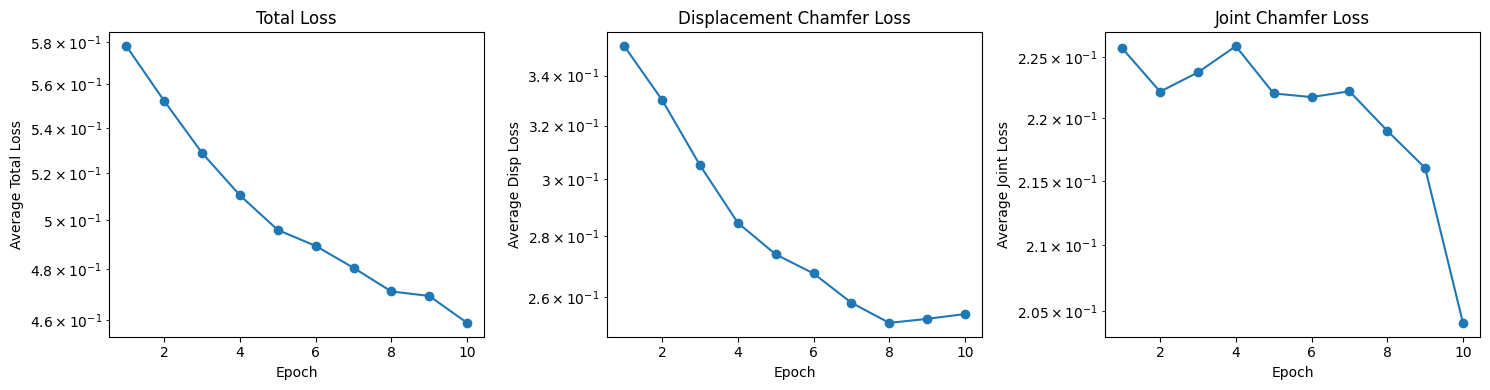

In [53]:
epochs_range = range(1, epochs+1)

# Create a single figure with 3 subplots side by side
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 4), tight_layout=True)

# Total loss
axes[0].semilogy(epochs_range, total_loss_history, marker='o')
axes[0].set_title("Total Loss")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Average Total Loss")

# Displacement loss
axes[1].semilogy(epochs_range, disp_loss_history, marker='o')
axes[1].set_title("Displacement Chamfer Loss")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Average Disp Loss")

# Joint loss
axes[2].semilogy(epochs_range, joint_loss_history, marker='o')
axes[2].set_title("Joint Chamfer Loss")
axes[2].set_xlabel("Epoch")
axes[2].set_ylabel("Average Joint Loss")

plt.show()

In [54]:
model.clustering_head.h = 0.067 # Rignet ideal
model.eval()

for batch in dl:
    verts = batch['vertices'].detach().clone()
    edges = batch['one_ring'].T.detach()
    vpg = batch['vertices_per_graph']

    vertex_splits = torch.split(torch.arange(verts.size(0)), vpg.tolist())

    joints_pred_list = model(batch)
    joints_gt_list = batch['joints_list']

    all_joints_gt = torch.cat(joints_gt_list).detach().clone()
    joints_gt_counts = [j.size(0) for j in joints_gt_list]
    joint_gt_splits = torch.split(torch.arange(all_joints_gt.size(0)), joints_gt_counts)

    all_joints_pred = torch.cat(joints_pred_list).detach().clone()
    joints_pred_counts = [j.size(0) for j in joints_pred_list]
    joints_pred_splits = torch.split(torch.arange(all_joints_pred.size(0)), joints_pred_counts)

    delta = 0.7
    for i, (v_idxs, j_gt_idxs, j_pred_idxs) in \
        enumerate(zip(vertex_splits, joint_gt_splits, joints_pred_splits)):
        # add z-offset
        verts[v_idxs, 2] += i * delta
        all_joints_gt[j_gt_idxs, 2] += i * delta
        all_joints_pred[j_pred_idxs, 2] += i * delta


    visualize_mesh_graph(
        vertices=verts.numpy(),
        edge_list=edges.numpy(),
        joints_gt=all_joints_gt.detach().numpy(),
        joints_pred=all_joints_pred.detach().numpy()
    )